In [ ]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
from pathlib import Path
from itertools import product

bids_root = str(Path.home()) + '/Documents/muniverse-data/Benchmarks/'

datasetnames = ['Caillet_et_al_2023', 'Grison_et_al_2025']
#datasetnames = ['Caillet_et_al_2023']

pipelinenames = ['cbss', 'scd']

global_rc = {pipeline: pd.DataFrame() for pipeline in pipelinenames}
source_rc = {pipeline: pd.DataFrame() for pipeline in pipelinenames}

for dataset in datasetnames:
    for pipeline in pipelinenames:
        path = bids_root + dataset + '-' + pipeline + '/'
        dataset_global_rc = pd.read_csv(path + 'report_card_globals.tsv', delimiter='\t')
        dataset_source_rc = pd.read_csv(path + 'report_card_sources.tsv', delimiter='\t')
        global_rc[pipeline] = pd.concat([global_rc[pipeline], dataset_global_rc], ignore_index=True)
        source_rc[pipeline] = pd.concat([source_rc[pipeline], dataset_source_rc], ignore_index=True)
       

In [23]:
dataset_of_interest = ['Caillet_et_al_2023', 'Grison_et_al_2025']

rows = [f"{d}-{a}" for d, a in product(dataset_of_interest, pipelinenames)]
columns = ['n_source_10', 'n_source_med', 'n_source_90', 
           'exp_var_10', 'exp_var_med', 'exp_var_90',
           'runtime_10', 'runtime_med', 'runtime_90']
summary = pd.DataFrame(np.nan, index=rows, columns=columns) 

sil_th = 0.9
cov_th = 0.3
min_num_spikes = 50

for dataset in dataset_of_interest:
    for pipeline in pipelinenames:
        row = f"{dataset}-{pipeline}"
        gdf = global_rc[pipeline].copy()
        gdf = gdf[(gdf['datasetname'] == dataset)]
        sdf = source_rc[pipeline].copy()
        sdf = sdf[(sdf['datasetname'] == dataset)]
        
        files = list(gdf['filename'])
        n_sources = np.zeros(len(files))
        for idx, file in enumerate(files):
            ssdf = sdf.copy()
            ssdf = sdf[(sdf['filename'] == file) & 
                       (sdf['sil'] > sil_th) & 
                       (sdf['cov_isi'] < cov_th) &
                       (sdf['n_spikes'] > min_num_spikes)]
            n_sources[idx] = ssdf.shape[0]

        summary.loc[row, 'n_source_med'] = np.percentile(n_sources,50) 
        summary.loc[row, 'n_source_10'] = np.percentile(n_sources,10)
        summary.loc[row, 'n_source_90'] = np.percentile(n_sources,90)   

        summary.loc[row, 'runtime_med'] = np.percentile(gdf['runtime'],50)
        summary.loc[row, 'runtime_10'] = np.percentile(gdf['runtime'],10)
        summary.loc[row, 'runtime_90'] = np.percentile(gdf['runtime'],100)
        summary.loc[row, 'exp_var_med'] = np.percentile(gdf['explained_var'],50)
        summary.loc[row, 'exp_var_10'] = np.percentile(gdf['explained_var'],10)
        summary.loc[row, 'exp_var_90'] = np.percentile(gdf['explained_var'],90) 

print(summary)          


                         n_source_10  n_source_med  n_source_90  exp_var_10  \
Caillet_et_al_2023-cbss          4.0          21.0         41.0    0.334533   
Caillet_et_al_2023-scd          10.0          23.0         55.0    0.395884   
Grison_et_al_2025-cbss          16.9          20.5         24.3    0.209013   
Grison_et_al_2025-scd           20.5          25.0         27.2    0.218948   

                         exp_var_med  exp_var_90  runtime_10  runtime_med  \
Caillet_et_al_2023-cbss     0.511107    0.597340  194.002042   253.608454   
Caillet_et_al_2023-scd      0.571730    0.617489  314.037709   503.508156   
Grison_et_al_2025-cbss      0.274396    0.366380  574.110736   887.502172   
Grison_et_al_2025-scd       0.316402    0.403453  544.713566   801.940235   

                          runtime_90  
Caillet_et_al_2023-cbss   362.880161  
Caillet_et_al_2023-scd    926.721425  
Grison_et_al_2025-cbss   1797.074193  
Grison_et_al_2025-scd    1325.549935  


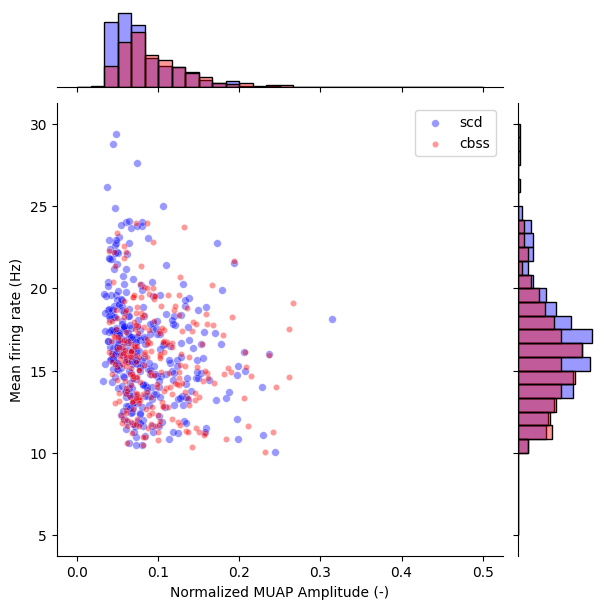

In [30]:
import seaborn as sns

sdf = source_rc['scd'].copy()

sdf = sdf[(sdf['sil'] > sil_th) & 
          (sdf['cov_isi'] < cov_th) &
          (sdf['n_spikes'] > min_num_spikes)]

x1 = np.asarray(sdf['muap_rms'])
y1 = np.asarray(sdf['mean_dr'])

sdf = source_rc['cbss'].copy()

sdf = sdf[(sdf['sil'] > sil_th) & 
          (sdf['cov_isi'] < cov_th) &
          (sdf['n_spikes'] > min_num_spikes)]

x2 = np.asarray(sdf['muap_rms'])
y2 = np.asarray(sdf['mean_dr'])

# Create a JointGrid
g = sns.JointGrid(x=x1, y=y1)

# Plot first dataset
g.plot_joint(sns.scatterplot, color="blue", label="scd",s=30, alpha=0.4)
sns.histplot(x=x1, color="blue", ax=g.ax_marg_x, alpha=0.4, bins=np.linspace(0,0.5,31))
sns.histplot(y=y1, color="blue", ax=g.ax_marg_y, alpha=0.4, bins=np.linspace(5,30,31))

# Overlay second dataset
sns.scatterplot(x=x2, y=y2, color="red", ax=g.ax_joint, label="cbss", s=20, alpha=0.4)
sns.histplot(x=x2, color="red", ax=g.ax_marg_x, alpha=0.4, bins=np.linspace(0,0.5,31))
sns.histplot(y=y2, color="red", ax=g.ax_marg_y, alpha=0.4, bins=np.linspace(5,30,31))

# Add legend
g.ax_joint.legend()
g.ax_joint.set_xlabel("Normalized MUAP Amplitude (-)")
g.ax_joint.set_ylabel("Mean firing rate (Hz)")

plt.show()